In [1]:
import dolfinx
from dolfinx import mesh, fem
from mpi4py import MPI
import numpy as np
from ufl import dx, grad, dot, TrialFunction, TestFunction

In [2]:
# 1. Verificar versión
print(f"DOLFINx version: {dolfinx.__version__}")

DOLFINx version: 0.9.0


In [3]:
# 2. Crear una malla simple
domain = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0.0, 0.0), (1.0, 1.0)),
    n=(8, 8)
)

In [7]:
# 3. Crear espacio de funciones
V = fem.functionspace(domain, ("P", 1))

In [8]:
# 4. Definir y resolver un problema simple de Poisson
u = TrialFunction(V)
v = TestFunction(V)
f = fem.Constant(domain, 1.0)

In [9]:
# Forma variacional
a = dot(grad(u), grad(v)) * dx
L = f * v * dx

In [10]:
# Condiciones de frontera
def boundary(x):
    return np.full(x.shape[1], True)

facets = mesh.locate_entities_boundary(domain, dim=1, marker=boundary)
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bc = fem.dirichletbc(value=np.array(0.0), dofs=dofs, V=V)

In [15]:
# Importar el solucionador
from dolfinx.fem.petsc import LinearProblem

# Resolver el sistema
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "cg"})
uh = problem.solve()

In [16]:
print("\nPrueba completada exitosamente!")
print(f"Número de celdas en la malla: {domain.topology.index_map(domain.topology.dim).size_global}")
print(f"Grados de libertad: {V.dofmap.index_map.size_global}")


Prueba completada exitosamente!
Número de celdas en la malla: 128
Grados de libertad: 81


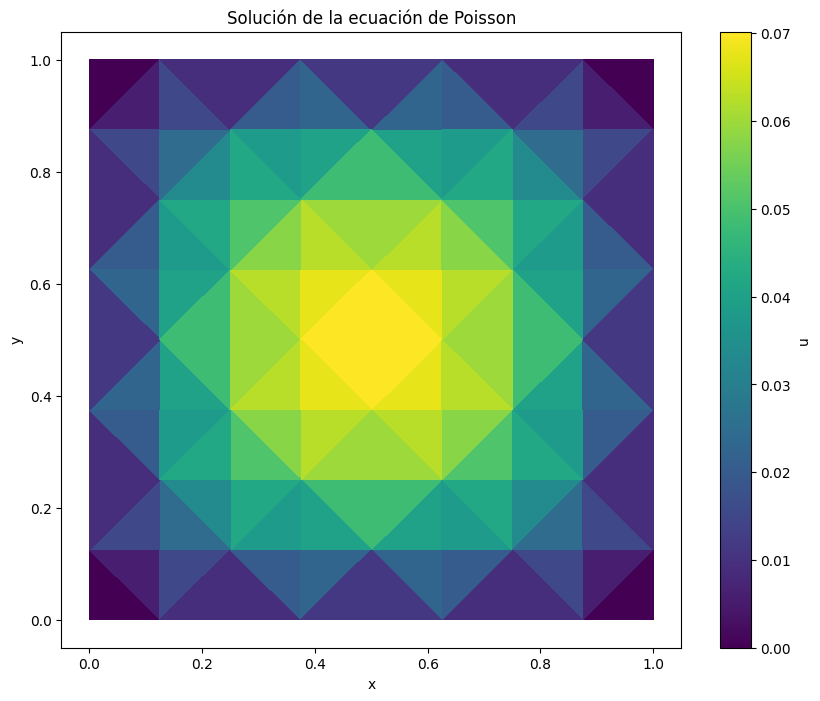

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener coordenadas y valores
vertices = uh.x.array
mesh = uh.function_space.mesh
x = mesh.geometry.x

# Crear el plot
plt.figure(figsize=(10, 8))
# Usamos triangulación directamente
plt.tripcolor(x[:, 0], x[:, 1], vertices)
plt.colorbar(label='u')
plt.title('Solución de la ecuación de Poisson')
plt.xlabel('x')
plt.ylabel('y')
plt.show()